![NeuronUnit Logo](https://raw.githubusercontent.com/scidash/assets/master/logos/neuronunit.png)
# Chapter 3
Back to [Chapter 2](chapter2.ipynb)

In the second chapter we tested a real ion channel model using data from the [OpenWorm](http://openworm.org) project.  Here we'll test a reduced neuron model using data from the [NeuroElectro](http://neuroelectro.org) project and from the [Allen Brain Institute Cell Types](http://celltypes.brain-map.org) database.  
### We'll test an Izhikevich model against data from a Layer V pyramidal cell in primary visual cortex

In [23]:
#import sys
#sys.path.insert(0,'/home/jovyan/work/dev/scidash/sciunit')
#sys.path.insert(0,'/home/jovyan/work/dev/scidash/neuronunit')
#sys.path.insert(0,'/home/jovyan/work/dev/neuroml/pyneuroml')

In [2]:
%matplotlib inline
import os,sys
import numpy as np
import matplotlib.pyplot as plt
import quantities as pq
import sciunit
import neuronunit
from neuronunit import aibs
from neuronunit.models.reduced import ReducedModel

In [3]:
import quantities as pq
from neuronunit import tests as nu_tests, neuroelectro
neuron = {'nlex_id': 'nifext_50'} # Layer V pyramidal cell
tests = []

dataset_id = 354190013  # Internal ID that AIBS uses for a particular Scnn1a-Tg2-Cre 
                        # Primary visual area, layer 5 neuron.
    
# Obtain the empirical rheobase current from the Allen Brain Insitute Cell Types database.  
observation = aibs.get_observation(dataset_id,'rheobase')
tests += [nu_tests.RheobaseTest(observation=observation)]
    
test_class_params = [(nu_tests.InputResistanceTest,None),
                     (nu_tests.TimeConstantTest,None),
                     (nu_tests.CapacitanceTest,None),
                     (nu_tests.RestingPotentialTest,None),
                     (nu_tests.InjectedCurrentAPWidthTest,None),
                     (nu_tests.InjectedCurrentAPAmplitudeTest,None),
                     (nu_tests.InjectedCurrentAPThresholdTest,None)
                    ]

# Obtain all other parameters from neuroelectro.org.
for cls,params in test_class_params:
    observation = cls.neuroelectro_summary_observation(neuron)
    tests += [cls(observation,params=params)]
    
# A hook to update all tests after the RheobaseTest to use the rheobase current (to produce exactly one AP)
def update_amplitude(test,tests,score):
    rheobase = score.prediction['value']
    for test in tests[1:]:
        if 'Injected' in test.name:
            # Set current injection to just suprathreshold
            test.params['injected_square_current']['amplitude'] = rheobase*1.01 
    
hooks = {tests[0]:{'f':update_amplitude}}
suite = sciunit.TestSuite("vm_suite",tests,hooks=hooks)

Getting Rheobase cached data value for from AIBS dataset 354190013
Getting Input Resistance data values from neuroelectro.org
http://www.neuroelectro.org/api/1/nes/?nlex=nifext_50&e__name=Input+Resistance
Getting Membrane Time Constant data values from neuroelectro.org
http://www.neuroelectro.org/api/1/nes/?nlex=nifext_50&e__name=Membrane+Time+Constant
Getting Cell Capacitance data values from neuroelectro.org
http://www.neuroelectro.org/api/1/nes/?nlex=nifext_50&e__name=Cell+Capacitance
Getting Resting membrane potential data values from neuroelectro.org
http://www.neuroelectro.org/api/1/nes/?nlex=nifext_50&e__name=Resting+membrane+potential
Getting Spike Half-Width data values from neuroelectro.org
http://www.neuroelectro.org/api/1/nes/?nlex=nifext_50&e__name=Spike+Half-Width
Getting Spike Amplitude data values from neuroelectro.org
http://www.neuroelectro.org/api/1/nes/?nlex=nifext_50&e__name=Spike+Amplitude
Getting Spike Threshold data values from neuroelectro.org
http://www.neuroe

### The Izhikevich model here is defined in an NeuroML2/LEMS file.  
### We will run it using the jNeuroML backend for simplicity, although this is *much* slower than the native NEURON backend.  

In [4]:
# This example is from https://github.com/OpenSourceBrain/IzhikevichModel.
IZHIKEVICH_PATH = os.getcwd()
LEMS_MODEL_PATH = os.path.join(IZHIKEVICH_PATH,'data/NeuroML2/LEMS_2007One.xml')
model = ReducedModel(LEMS_MODEL_PATH,name='vanilla',backend='jNeuroML')

### Run a series of tests.  The RheobaseTest is run first to obtain the rheobase current to use in all the other tests.

In [5]:
score_matrix = suite.judge(model)

Injected 300.0 pA current and got 54 spikes
Injected -0.0 pA current and got 0 spikes
Injected 150.0 pA current and got 25 spikes
Injected 75.0 pA current and got 8 spikes
Injected 37.5 pA current and got 0 spikes
Injected 56.25 pA current and got 3 spikes
Injected 46.875 pA current and got 0 spikes
Injected 51.5625 pA current and got 0 spikes
Injected 53.90625 pA current and got 2 spikes
Injected 52.734375 pA current and got 1 spikes
Injected 52.1484375 pA current and got 1 spikes
Highest subthreshold current is 51.56 pA
Lowest suprathreshold current is 52.15 pA


### Now we can sweep across a parameter (the resting potential) and run the same test suite on a model corresponding to each value of this parameter.

In [6]:
models = []
for vr in np.linspace(-75,-50,6):
    model = ReducedModel(LEMS_MODEL_PATH, 
                         name='V_rest=%dmV' % vr, 
                         attrs={'//izhikevich2007Cell':
                                    {'vr':'%d mV' % vr}
                               })
    #model.skip_run = True
    models.append(model)
suite.set_verbose(False) # Turn off most print statements.  
score_matrix = suite.judge(models)

Highest subthreshold current is 181.05 pA
Lowest suprathreshold current is 181.64 pA


Injected 300.0 pA current and got 50 spikes
Injected -0.0 pA current and got 0 spikes
Injected 150.0 pA current and got 8 spikes
Injected 75.0 pA current and got 0 spikes
Injected 112.5 pA current and got 0 spikes
Injected 131.25 pA current and got 2 spikes
Injected 121.875 pA current and got 0 spikes
Injected 126.5625 pA current and got 0 spikes
Injected 128.90625 pA current and got 0 spikes
Injected 130.078125 pA current and got 1 spikes
Injected 129.4921875 pA current and got 1 spikes
Highest subthreshold current is 128.91 pA
Lowest suprathreshold current is 129.49 pA


Injected 300.0 pA current and got 53 spikes
Injected -0.0 pA current and got 0 spikes
Injected 150.0 pA current and got 19 spikes
Injected 75.0 pA current and got 0 spikes
Injected 112.5 pA current and got 9 spikes
Injected 93.75 pA current and got 4 spikes
Injected 84.375 pA current and got 0 spikes
Injected 89.0625 pA current and got 2 spikes
Injected 86.71875 pA current and got 1 spikes
Injected 85.546875 pA current and got 0 spikes
Injected 86.1328125 pA current and got 0 spikes
Highest subthreshold current is 86.13 pA
Lowest suprathreshold current is 86.72 pA


Injected 300.0 pA current and got 54 spikes
Injected -0.0 pA current and got 0 spikes
Injected 150.0 pA current and got 25 spikes
Injected 75.0 pA current and got 8 spikes
Injected 37.5 pA current and got 0 spikes
Injected 56.25 pA current and got 3 spikes
Injected 46.875 pA current and got 0 spikes
Injected 51.5625 pA current and got 0 spikes
Injected 53.90625 pA current and got 2 spikes
Injected 52.734375 pA current and got 1 spikes
Injected 52.1484375 pA current and got 1 spikes
Highest subthreshold current is 51.56 pA
Lowest suprathreshold current is 52.15 pA


Injected 300.0 pA current and got 55 spikes
Injected -0.0 pA current and got 0 spikes
Injected 150.0 pA current and got 28 spikes
Injected 75.0 pA current and got 13 spikes
Injected 37.5 pA current and got 5 spikes
Injected 18.75 pA current and got 0 spikes
Injected 28.125 pA current and got 2 spikes
Injected 23.4375 pA current and got 0 spikes
Injected 25.78125 pA current and got 0 spikes
Injected 26.953125 pA current and got 1 spikes
Injected 26.3671875 pA current and got 1 spikes
Highest subthreshold current is 25.78 pA
Lowest suprathreshold current is 26.37 pA


Injected 300.0 pA current and got 54 spikes
Injected -0.0 pA current and got 0 spikes
Injected 150.0 pA current and got 30 spikes
Injected 75.0 pA current and got 16 spikes
Injected 37.5 pA current and got 9 spikes
Injected 18.75 pA current and got 5 spikes
Injected 9.375 pA current and got 1 spikes
Injected 4.6875 pA current and got 0 spikes
Injected 7.03125 pA current and got 0 spikes
Injected 8.203125 pA current and got 0 spikes
Injected 8.7890625 pA current and got 0 spikes
Highest subthreshold current is 8.79 pA
Lowest suprathreshold current is 9.38 pA


<IPython.core.display.Javascript object>

,Mean,RheobaseTest,InputResistanceTest,TimeConstantTest,CapacitanceTest,RestingPotentialTest,InjectedCurrentAPWidthTest,InjectedCurrentAPAmplitudeTest,InjectedCurrentAPThresholdTest
V_rest=-75mV,0.409,Ratio = 1.40,Z = -0.96,Z = -1.34,Z = -0.15,Z = -1.03,Z = -0.75,Z = -1.32,Z = 1.75
V_rest=-70mV,0.495,Ratio = 1.00,Z = -0.87,Z = -1.20,Z = -0.15,Z = -0.27,Z = -0.71,Z = -1.45,Z = 1.97
V_rest=-65mV,0.471,Ratio = 0.67,Z = -0.73,Z = -1.00,Z = -0.14,Z = 0.50,Z = -0.66,Z = -1.59,Z = 2.18
V_rest=-60mV,0.430,Ratio = 0.40,Z = -0.53,Z = -0.69,Z = -0.12,Z = 1.26,Z = -0.62,Z = -1.72,Z = 2.39
V_rest=-55mV,0.448,Ratio = 0.20,Z = -0.21,Z = -0.20,Z = -0.10,Z = 2.03,Z = -0.57,Z = -1.86,Z = 2.60
V_rest=-50mV,0.365,Ratio = 0.07,Z = 0.29,Z = 0.63,Z = -0.06,Z = 2.79,Z = -0.51,Z = -2.00,Z = 2.81


In [9]:
score_matrix.show_mean = True # Show the mean value across test scores. 
                              # The mean is computed using the sort_key attribute, which is in the range [0,1] for
                              # all Score types
score_matrix.sortable = True # Make the ScoreMatrix sortable (and searchable)
score_matrix

<IPython.core.display.Javascript object>

,Mean,RheobaseTest,InputResistanceTest,TimeConstantTest,CapacitanceTest,RestingPotentialTest,InjectedCurrentAPWidthTest,InjectedCurrentAPAmplitudeTest,InjectedCurrentAPThresholdTest
V_rest=-75mV,0.409,Ratio = 1.40,Z = -0.96,Z = -1.34,Z = -0.15,Z = -1.03,Z = -0.75,Z = -1.32,Z = 1.75
V_rest=-70mV,0.495,Ratio = 1.00,Z = -0.87,Z = -1.20,Z = -0.15,Z = -0.27,Z = -0.71,Z = -1.45,Z = 1.97
V_rest=-65mV,0.471,Ratio = 0.67,Z = -0.73,Z = -1.00,Z = -0.14,Z = 0.50,Z = -0.66,Z = -1.59,Z = 2.18
V_rest=-60mV,0.430,Ratio = 0.40,Z = -0.53,Z = -0.69,Z = -0.12,Z = 1.26,Z = -0.62,Z = -1.72,Z = 2.39
V_rest=-55mV,0.448,Ratio = 0.20,Z = -0.21,Z = -0.20,Z = -0.10,Z = 2.03,Z = -0.57,Z = -1.86,Z = 2.60
V_rest=-50mV,0.365,Ratio = 0.07,Z = 0.29,Z = 0.63,Z = -0.06,Z = 2.79,Z = -0.51,Z = -2.00,Z = 2.81


### Let's take a look at a sweep from one of these models ($V_{rest} = -55 mV$) obtained at the rheobase current.  

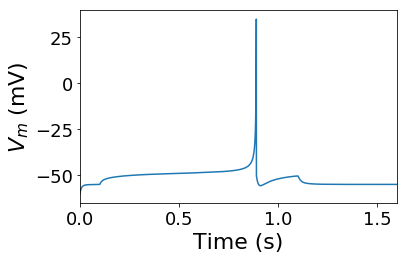

In [22]:
import matplotlib as mpl
mpl.rcParams['font.size'] = 18
vm = score_matrix[tests[0]][4].related_data['vm'].rescale('mV') # Plot the rheobase current (test 3) 
                                                                # from v_rest = -55 mV (model 4)
ax = plt.gca()
ax.plot(vm.times,vm)
y_min = float(vm.min()-5.0*pq.mV)
y_max = float(vm.max()+5.0*pq.mV)
ax.set_xlim(0,1.6)
ax.set_ylim(y_min,y_max)
ax.set_xlabel('Time (s)',size=22)
ax.set_ylabel('$V_m$ (mV)',size=22);
plt.tight_layout()